#### Necessary imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import neighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from datetime import datetime, date, time, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
import matplotlib.ticker as mtick
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from scipy.stats import spearmanr
import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgbm

#### Read Data

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
train['first_payment_month'] = train['first_payment_date'].str.split('/').str[0]
train['gap'] = train['first_payment_month'].astype(int) - train['origination_date'].str.split('-').str[1].astype(int)
train['first_payment_month'] = train['first_payment_month']

test['first_payment_month'] = test['first_payment_date'].str.split('-').str[0]
test['first_payment_month'] = test['first_payment_month'].map({'Feb':'02', 'Mar': '03', 'Apr': '04', 
                                                              'May': '05'})
test['gap'] = test['first_payment_month'].astype(int) - test['origination_date'].str.split('/').str[1].astype(int)

In [4]:
ID = 'loan_id'
target = 'm13'
categorical_cols = ['source', 'financial_institution', 'loan_purpose', 'first_payment_month']
date_cols = ['origination_date', 'first_payment_date']
continuous_cols = [c for c in train.columns if c not in [ID, target]+categorical_cols+date_cols]

#### Describe

In [5]:
train.describe()

,loan_id,interest_rate,unpaid_principal_bal,loan_term,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,insurance_percent,co-borrower_credit_score,...,m5,m6,m7,m8,m9,m10,m11,m12,m13,gap
count,1.160580e+05,116058.000000,1.160580e+05,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,...,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000
mean,5.494155e+11,3.868961,2.082262e+05,292.280997,67.431939,1.593186,30.742293,769.926778,2.786288,459.611565,...,0.003533,0.003421,0.004162,0.004825,0.005359,0.006617,0.007109,0.008065,0.005480,2.006445
std,2.597560e+11,0.461020,1.146851e+05,89.762415,17.291719,0.491242,9.730798,42.210706,8.096464,381.946926,...,0.082638,0.087553,0.100961,0.113128,0.128242,0.148430,0.162884,0.178128,0.073824,0.240794
min,1.000009e+11,2.250000,1.100000e+04,60.000000,6.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,3.244656e+11,3.500000,1.200000e+05,180.000000,57.000000,1.000000,23.000000,751.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,5.486239e+11,3.875000,1.830000e+05,360.000000,72.000000,2.000000,31.000000,782.000000,0.000000,740.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,7.743034e+11,4.125000,2.780000e+05,360.000000,80.000000,2.000000,39.000000,800.000000,0.000000,791.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
max,9.999971e+11,6.750000,1.200000e+06,360.000000,97.000000,2.000000,64.000000,840.000000,40.000000,836.000000,...,7.000000,8.000000,9.000000,10.000000,11.000000,12.000000,13.000000,14.000000,1.000000,3.000000


#### EDA + Viz
##### Target

Number of deliq: 636
Number of non-deliq: 115422


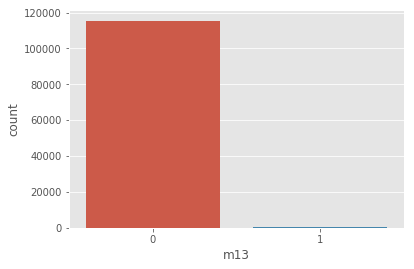

In [6]:
sns.countplot(x=target, data=train)
non_deliq, deliq = train[target].value_counts()
print('Number of deliq: %s' %deliq)
print('Number of non-deliq: %s' %non_deliq)

##### Categorical data group bys

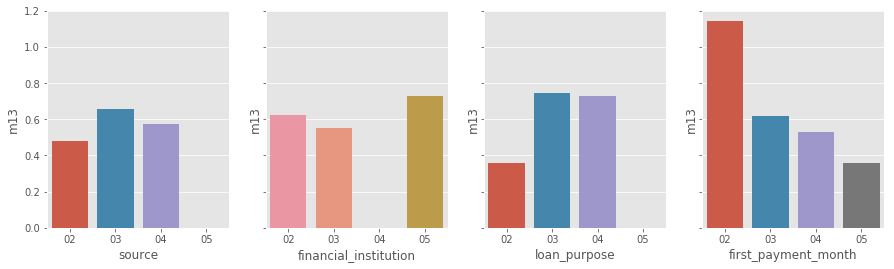

In [7]:
fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=(15,4))
axes = [ax1, ax2, ax3, ax4]
for idx, col in enumerate(categorical_cols):
    temp = train.groupby(col).agg({target: "mean"})*100
    temp.reset_index(inplace=True)
    sns.barplot(x=col, y=target, data=temp, ax=axes[idx])
plt.show()

##### Continuous columns wrt to target

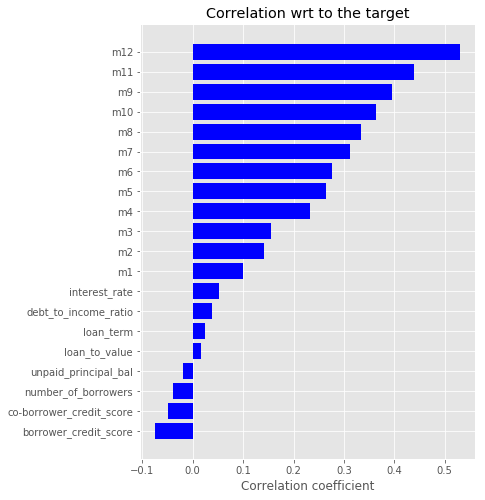

In [8]:
features = []
values = []
for col in continuous_cols:
    features.append(col)
    values.append(spearmanr(train[col].values, train[target].values)[0])
corr_df = pd.DataFrame({'col_labels':features, 'corr_values':values})
corr_df = corr_df.sort_values(by='corr_values')
 
corr_df = corr_df[(corr_df['corr_values']>0.01) | (corr_df['corr_values']<-0.01)]
ind = np.arange(corr_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(6,8))
rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='b')
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation wrt to the target")
plt.show()

#### Correlation matrix

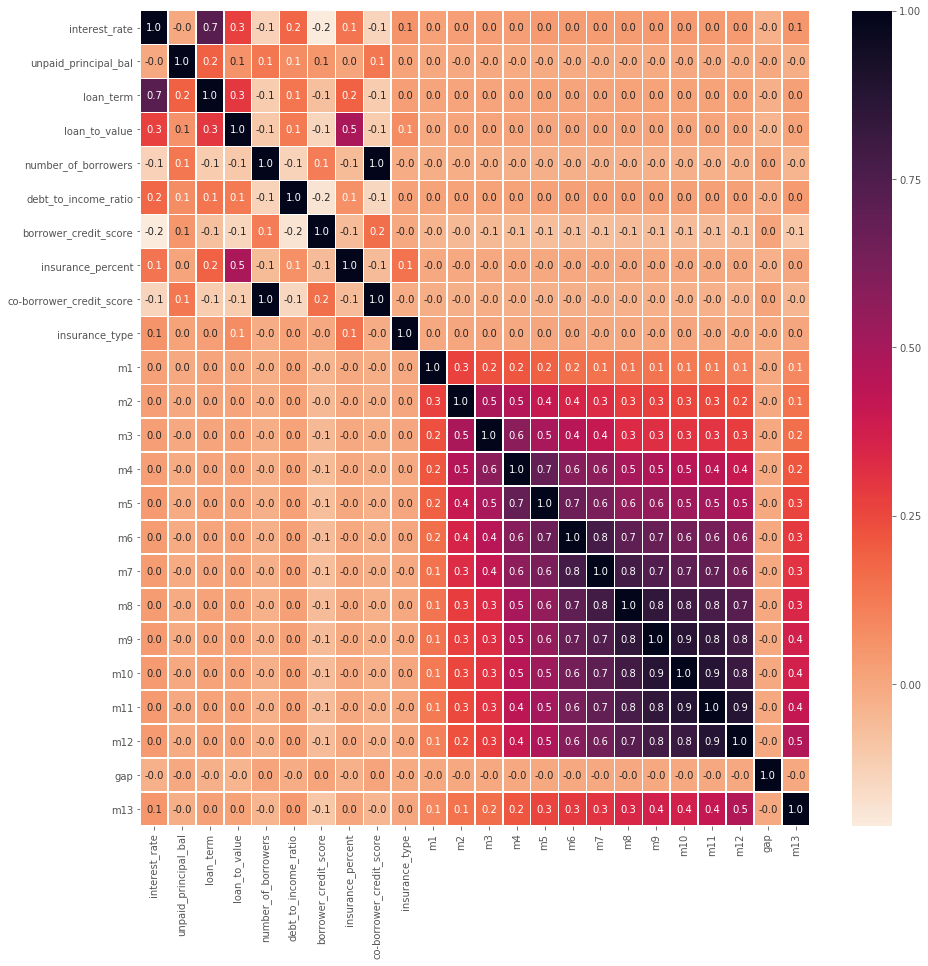

In [9]:
f,ax = plt.subplots(figsize=(15, 15))
sns.heatmap(train[continuous_cols+[target]].corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax,
           cmap=sns.cm.rocket_r)

###### Looks like m6-mn are very correlated

##### Inserting rando features here

In [16]:
train['interest_X_unpaid_principal_bal_X_loan_term'] = train['interest_rate'] * train['unpaid_principal_bal'] * train['loan_term']/12.0
train['avg_credit_score'] = (train['borrower_credit_score'] + train['co-borrower_credit_score'])/train['number_of_borrowers']
train['liabilities'] = (train['loan_to_value'] + train['debt_to_income_ratio'] - train['insurance_percent'])/train['avg_credit_score']

In [17]:
test['interest_X_unpaid_principal_bal_X_loan_term'] = test['interest_rate'] * test['unpaid_principal_bal'] * test['loan_term']/12.0
test['avg_credit_score'] = (test['borrower_credit_score'] + test['co-borrower_credit_score'])/test['number_of_borrowers']
test['liabilities'] = (test['loan_to_value'] + test['debt_to_income_ratio'] -test['insurance_percent'])/test['avg_credit_score']

In [18]:
T = 12.0 
K = 1
weights = []
for i in range(1, 13):
    timeElapsed = i
    W=K*np.exp(timeElapsed/T)
    weights.append(W)
print weights

[1.086904049521229, 1.1813604128656459, 1.2840254166877414, 1.3956124250860895, 1.5168967963882134, 1.6487212707001282, 1.7920018256557555, 1.9477340410546757, 2.117000016612675, 2.300975890892825, 2.5009400136621287, 2.718281828459045]


In [19]:
train['m_hist'] = 0.0
test['m_hist'] = 0.0
for i in range(len(weights)):
    train['m_hist'] += (weights[i] * train['m'+str(i+1)])
    test['m_hist'] += (weights[i] * test['m'+str(i+1)])

In [20]:
def ema(s, n):
    sma = sum(s[:n]) / n
    multiplier = 2 / float(1 + n)
    return ( (s[n] - sma) * multiplier) + sma

In [21]:
m_cols = "m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12".split(",")
train['ma'] = train[m_cols].apply(lambda x: ema(x, 11), axis=1)
test['ma'] = test[m_cols].apply(lambda x: ema(x, 11), axis=1)

In [22]:
train.head()

,loan_id,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,...,m11,m12,m13,first_payment_month,gap,interest_X_unpaid_principal_bal_X_loan_term,avg_credit_score,liabilities,m_hist,ma
0,268055008619,Z,"Turner, Baldwin and Rhodes",4.250,214000,360,2012-03-01,05/2012,95,1.0,...,0,0,1,05,2,27285000.0,694.0,0.125360,1.792002,0.000000
1,672831657627,Y,"Swanson, Newton and Miller",4.875,144000,360,2012-01-01,03/2012,72,1.0,...,1,0,1,03,2,21060000.0,697.0,0.166428,2.500940,0.000000
2,742515242108,Z,Thornton-Davis,3.250,366000,180,2012-01-01,03/2012,49,1.0,...,0,0,1,03,2,17842500.0,780.0,0.105128,0.000000,0.000000
3,601385667462,X,OTHER,4.750,135000,360,2012-02-01,04/2012,46,2.0,...,1,1,1,04,2,19237500.0,635.5,0.141621,9.637198,0.166667
4,273870029961,X,OTHER,4.750,124000,360,2012-02-01,04/2012,80,1.0,...,10,11,1,04,2,17670000.0,681.0,0.180617,139.188875,6.000000


In [23]:
train['balanced_risk'] = train['m_hist']/train['avg_credit_score']
train['balanced_risk_ema'] = train['ma']/train['avg_credit_score']

test['balanced_risk'] = test['m_hist']/test['avg_credit_score']
test['balanced_risk_ema'] = test['ma']/test['avg_credit_score']

In [24]:
#Removing m6 to m11 
usecols_continuous = continuous_cols + ['interest_X_unpaid_principal_bal_X_loan_term', 'avg_credit_score', 'liabilities', 'm_hist', 'ma', 'balanced_risk', 'balanced_risk_ema']
usecols = usecols_continuous + categorical_cols

In [25]:
dtrain = pd.get_dummies(train[usecols], drop_first=True)
dtest = pd.get_dummies(test[usecols], drop_first=True)

In [26]:
dtrain.columns

Index([u'interest_rate', u'unpaid_principal_bal', u'loan_term',
       u'loan_to_value', u'number_of_borrowers', u'debt_to_income_ratio',
       u'borrower_credit_score', u'insurance_percent',
       u'co-borrower_credit_score', u'insurance_type', u'm1', u'm2', u'm3',
       u'm4', u'm5', u'm6', u'm7', u'm8', u'm9', u'm10', u'm11', u'm12',
       u'gap', u'interest_X_unpaid_principal_bal_X_loan_term',
       u'avg_credit_score', u'liabilities', u'm_hist', u'ma', u'balanced_risk',
       u'balanced_risk_ema', u'source_Y', u'source_Z',
       u'financial_institution_Browning-Hart',
       u'financial_institution_Chapman-Mcmahon',
       u'financial_institution_Cole, Brooks and Vincent',
       u'financial_institution_Edwards-Hoffman',
       u'financial_institution_Martinez, Duffy and Bird',
       u'financial_institution_Miller, Mcclure and Allen',
       u'financial_institution_Nicholson Group',
       u'financial_institution_OTHER',
       u'financial_institution_Richards-Walters',
  

In [27]:
dtrain.fillna(0, inplace=True)
dtest.fillna(0, inplace=True)
dtrain = dtrain.replace([np.inf, -np.inf], 0)
dtest = dtest.replace([np.inf, -np.inf], 0)
cols_to_scale = ['interest_rate', u'unpaid_principal_bal', u'loan_term',
       u'loan_to_value', u'number_of_borrowers', u'debt_to_income_ratio',
       u'borrower_credit_score', u'insurance_percent',
       u'co-borrower_credit_score', u'insurance_type', u'm1', u'm2', u'm3',
       u'm4', u'm5', u'm6', u'm7', u'm8', u'm9', u'm10', u'm11',u'm12', u'interest_X_unpaid_principal_bal_X_loan_term',
       u'avg_credit_score', u'liabilities', u'm_hist', u'ma', u'balanced_risk',
       u'balanced_risk_ema']
sc = StandardScaler()
sc.fit(dtrain[cols_to_scale])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [28]:
other_cols = [c for c in dtrain.columns if c not in cols_to_scale]
X = np.concatenate([sc.transform(dtrain[cols_to_scale]), dtrain[other_cols].values], axis=1)
y = train[target].values
X_hat = np.concatenate([sc.transform(dtest[cols_to_scale]), dtest[other_cols].values], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1883)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34634
           1       0.75      0.35      0.48       184

   micro avg       1.00      1.00      1.00     34818
   macro avg       0.87      0.67      0.74     34818
weighted avg       1.00      1.00      1.00     34818



Text(0,0.5,'importance')

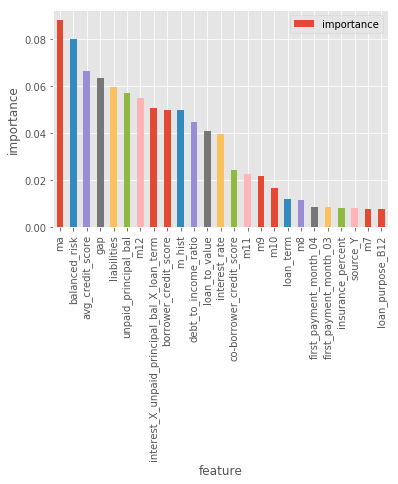

In [29]:
rf = RandomForestClassifier(
    n_estimators=200,
    criterion="gini",
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features="auto",
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    bootstrap=True,
    oob_score=False,
    n_jobs=12,
    random_state=None,
    verbose=0,
    warm_start=False,
    class_weight=None,
)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print classification_report(y_test, y_pred)
fi = rf.feature_importances_
feature_cols = dtrain.columns
importance = pd.DataFrame(
    {"feature": feature_cols, "importance": rf.feature_importances_}
)

importance.sort_values(
    by="importance",
    axis=0,
    ascending=False,
    inplace=True,
    kind="quicksort",
    na_position="last",
)
importance[:25].plot(x="feature", y="importance", kind="bar")
plt.ylabel("importance")

In [30]:
np.count_nonzero(y_test)

184

In [ ]:
# cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
# models = {}
# for (tr, te), i in zip(cv.split(X, y), range(5)):
#     print ("Running cv " + str(i))
#     rf = RandomForestClassifier(
#         n_estimators=200,
#         criterion="gini",
#         max_depth=None,
#         min_samples_split=2,
#         min_samples_leaf=1,
#         min_weight_fraction_leaf=0.0,
#         max_features="sqrt",
#         max_leaf_nodes=None,
#         min_impurity_decrease=0.0,
#         bootstrap=True,
#         oob_score=False,
#         n_jobs=12,
#         random_state=13)
#     rf.fit(X[tr], y[tr])
#     y_pred = rf.predict_proba(X[te])[:,1]
#     y_pred = np.where(y_pred>0.2, 1, 0)
#     models['rf_' + str(i)] = f1_score(y[te], y_pred)
    
#     lr = LogisticRegression(penalty="l1", C=1).fit(X[tr], y[tr])
#     y_pred = lr.predict_proba(X[te])[:,1]
#     y_pred = np.where(y_pred>0.2, 1, 0)
#     models['lr_' + str(i)] = f1_score(y[te], y_pred)
    
#     bst = XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, verbosity=1, silent=True, 
#                     objective='binary:logistic', booster='gbtree', n_jobs=12, nthread=None, gamma=0, min_child_weight=1, max_delta_step=2, subsample=0.7, colsample_bytree=0.7,  reg_alpha=0, 
#                     random_state=1883, seed=None, missing=None, eval_metric='auc')

#     bst.fit(X[tr], y[tr])
#     y_pred = bst.predict_proba(X[te])[:,1]
#     y_pred = np.where(y_pred>0.2, 1, 0)
#     models['xgb_' + str(i)] = f1_score(y[te], y_pred)
# print("Mean is %f" %np.mean(models.values()))
# print("SD is %f" %np.std(models.values()))

In [32]:
rf = RandomForestClassifier(
        n_estimators=200,
        criterion="gini",
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        min_weight_fraction_leaf=0.0,
        max_features="sqrt",
        max_leaf_nodes=None,
        min_impurity_decrease=0.0,
        bootstrap=True,
        oob_score=False,
        n_jobs=12,
        random_state=13)
rf.fit(X, y)
y_pred_rf = rf.predict_proba(X_hat)[:,1]
    
lr = LogisticRegression(penalty="l1", C=1).fit(X, y)
y_pred_lr = lr.predict_proba(X_hat)[:,1]
    
bst = XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, verbosity=1, silent=True, 
                    objective='binary:logistic', booster='gbtree', n_jobs=12, nthread=None, gamma=0, min_child_weight=1, max_delta_step=2, subsample=0.7, colsample_bytree=0.7,  reg_alpha=0, 
                    random_state=1883, seed=None, missing=None, early_stopping_rounds=10, eval_metric='auc')

bst.fit(X, y)
y_pred_xgb = bst.predict_proba(X_hat)[:,1]

In [86]:
pred_df = pd.DataFrame()
pred_df[ID] = test.loan_id
pred_df['m13'] = 0.0
pred_df['lr'] = y_pred_lr
pred_df['bst'] = y_pred_xgb
pred_df['rf'] = y_pred_rf

In [87]:
pred_df.head()

,loan_id,m13,lr,bst,rf
0,1,0.0,0.001386,0.001159,0.000
1,2,0.0,0.002397,0.001997,0.000
2,3,0.0,0.008834,0.007854,0.005
3,4,0.0,0.000827,0.000762,0.000
4,5,0.0,0.000542,0.000864,0.000


In [88]:
pred_df['m13'] = (0.4*(pred_df['rf'])) + (0.2*(pred_df['lr'])) + (0.4*(pred_df['bst']))

In [89]:
pred_df = pred_df[[ID, target]]

In [95]:
pred_df.loc[(pred_df['m13']>=0.135)].shape

(189, 2)

In [96]:
pred_df.shape

(35866, 2)

In [97]:
mask = (pred_df['m13']>=0.135)
pred_df.loc[mask, target] = 1
pred_df.loc[~mask, target] = 0

In [98]:
pred_df['m13'] = pred_df['m13'].astype(int)

In [99]:
pred_df.m13.value_counts()

0    35677
1      189
Name: m13, dtype: int64

In [100]:
pred_df.to_csv("submissions/submission_v3.csv", index=False)